In [1]:
#hide
import sys
import time
import numpy as np
import numpy.linalg as la
import pandas as pd
from scipy.stats import truncnorm
from matplotlib import animation, pyplot as plt
import proplot as plot
import seaborn as sns
from tqdm import trange

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import plotting as myplt, animation as myanim

In [2]:
#hide
%load_ext cython
import Cython

In [3]:
#hide
from scipy.constants import epsilon_0, elementary_charge, speed_of_light, pi
proton_mass = 0.938272029 # [GeV/c^2]
classical_proton_radius = 1.53469e-18 # [m]

In [4]:
#hide
plt.rcParams['animation.html'] = 'jshtml'
plot.rc['figure.facecolor'] = 'white'
plot.rc['savefig.dpi'] = 'figure'

# Particle-in-cell simulation
> An introduction to electrostatic PIC solvers

- toc: true 
- badges: false
- comments: true
- categories: [physics, accelerators, simulation]
- image: images/chart-preview.png

In my research I utilize [PyORBIT](link), one of many particle-in-cell (PIC) simulation codes for particle accelerators. These codes track a beam of particles though the time-varying electromagnetic fields provided by an accelerator; we call this *external focusing*. In addition to external focusing, there are also *internal* forces to consider caused by the electromagnetic interactions between the beam particles. These are known as *space charge* forces, which refers to the charge density of the beam in free space. This post examines the use of computer simulation to understand space charge effects by building a simple simulation engine in Python. Links to relevant books, lectures, and programs are included at the end; I am basically restating parts of these works. I just always find that I understand things better after writing them down.

## Theoretical model 

We'll use *bunch* to refer to a group of particles in three-dimensional (3D) space. We will use a local cartesian coordinate system whose origin moves with the center of the bunch as shown below:

<img src='images_2021-02-15/coordinate_system.png' width=500>

The $s$ coordinate specifies the position of the bunch in the accelerator, and the path can be curved. Now for a few simplifying assumptions. First, we will assume the beam is in free space so there are no external fields. Second, we will assume the center of the bunch is moving at a constant velocity $\beta c$, where $c$ is the speed of light. In this way we can eliminate the time variable by $s = \beta c t$. Hence, we use the slope $x' = dx/ds$ instead of the velocity. Third, we will assume that all the particles move at the same velocity. Fourth, we will ignore the dynamics in the $z$ direction, assuming the bunch has a uniform charge density in this dimension and is infinitely long, thus treating each particle as an infinite line charge. Finally, we neglect any magnetic fields generated by the beam. All this being said, the equations of motion can be written as 

$$ \mathbf{x}'' = \frac{q}{mc^2\beta^2\gamma^3} \mathbf{E}, \tag{1}$$

where $\mathbf{x} = [x, y]^T$ is the coordinate vector, $\mathbf{E} = [E_x, E_y]^T$ is the electric field, and $\gamma = \sqrt{1 - \beta^2}$ $s$. 

Let's first address the factor $\gamma^{-3}$ in the equation of motion. This means that the space charge force goes to zero as the velocity approaches the speed of light. Ths is because the moving charges generate an attractive magnetic force which grows with velocity, completely cancelling the electric repulsion in the limit $v \rightarrow c$. One may ask: what about the rest frame, in which there is no magnetic field? But special relativity says that electrogmagnetic fields change with reference frame. Using the transformations defined [here](https://en.wikipedia.org/wiki/Classical_electromagnetism_and_special_relativity), you can quickly prove that 

$$\mathbf{E}_{lab} = \frac{\mathbf{E}_{rest}}{\gamma}. \tag{2}$$

This inverse relationship between velocity and the space charge force has real-life consequences. It tells us that space charge is important if 1) the beam is very intense, meaning there are many particles in a small area, or 2) the beam is very energetic, meaning it is moving extremely fast. For example, space charge can usually be ignored in electron beams, which move near the speed of light for very modest energies due to their tiny mass, but is significant in high-intensity, low-energy hadron accelerators such as [FRIB](https://frib.msu.edu), [SNS](https://neutrons.ornl.gov/sns), and [ESS](https://europeanspallationsource.se).

We should now address the difficulty in determining the evolution of this system: the force on a particle in an $n$-particle bunch depends on the positions of the other $n - 1$ particles in the beam. The approach of statistical mechanics to this problem is to introduce a *distribution function* $f(\mathbf{x}, \mathbf{x}', t)$ which gives the number of particles in an infinitesimal volume of phase space. The Vlasov-Poisson system of equations determines the evolution of $f$ (as long as we ignore collisions between particles and any magnetic fields):

$$\frac{\partial{f}}{\partial{s}} + \mathbf{x}'\cdot \frac{\partial{f}}{\partial{\mathbf{x}}} + \mathbf{x}'' \cdot \frac{\partial{f}}{\partial{\mathbf{x}'}}. \tag{3}$$

We know $\mathbf{x''}$ from Eq. (1). The electric field is obtained from the Poisson's equation:

$$ \nabla \cdot \mathbf{E} = -\nabla^2 \phi = \frac{\rho}{\varepsilon_0}. \tag{4}$$

Finally, the transverse charge density $\rho$ is determined by

$$\rho = q \int{f dx'dy'}. \tag{5}$$

Although these equations are easy to write down, they are generally impossible to solve analytically. We need to turn to a computer for help.

## Computational method

We could try to solve the Vlasov equation directly, but this is difficult, especially in 2D or 3D, . On the other end of the spectrum, we could abandon the notion of a fluid in phase space and just track each particle individually, computing the forces using direct sums. But this is infeasible with current hardware; the time complexity would by $O(n^2)$, where $n$ is the number of particles, and $n$ may be on the order of $10^{14}$.

In comes the particle-in-cell (PIC) method. The idea is to track a group of *macroparticles*, each of which represents a large number of real particles, according to Eq. (1). The fields, however, are solved from Eq. (4). The key step is transforming back and forth between a discrete and continuous representation of the bunch. The simulation loop for the PIC method is shown below.

<img src='images_2021-02-15/picloop.png' width=500>

In the next sections I will discuss each of these steps and implement them in Python code. Let's first create a `Bunch` class, which is a simple container for the bunch coordinates. (*Note: there are some constants and helper functions I've imported that I don't define. The whole package is posted on [GitHub](https://github.com/austin-hoover/pic).*)

In [5]:
#hide
def rotation_matrix(phi):
    """2D rotation matrix (cw)."""
    C, S = np.cos(phi), np.sin(phi)
    return np.array([[C, S], [-S, C]])


def apply(M, X):
    """Apply matrix M to all rows of X."""
    return np.apply_along_axis(lambda x: np.matmul(M, x), 1, X)


def norm_rows(X):
    """Normalize all rows of X to unit length."""
    return np.apply_along_axis(lambda x: x/la.norm(x), 1, X)
    
    
def rand_rows(X, k):
    """Return k random rows of X."""
    idx = np.random.choice(X.shape[0], k, replace=False)
    return X[idx, :]


def Vmat2D(alpha, beta):
    """Return symplectic normalization matrix for 2D phase space."""
    return np.sqrt(1/beta)* np.array([[beta, 0], [alpha, 1]])
    
    
def get_perveance(line_density, beta, gamma):
    """Return the dimensionless space charge perveance."""
    return 2 * classical_proton_radius * line_density / (beta**2 * gamma**3)
    
    
def get_sc_factor(charge, mass, velocity, gamma):
    """Return factor defined by x'' = factor * (x electric field component).
    
    Units of `charge` are Coulombs, units of `rest_energy` are GeV.
    """
    return charge / (mass * velocity**2 * gamma**3)

In [6]:
#hide
class DistGenerator:
    """Class to generate particle distributions in 4D phase space.
    
    The four dimensions are the transverse positions and slopes {x, x', y, y'}.
    Note that 'normalized space', is referring to normalization in the 2D 
    sense, in which the x-x' and y-y' ellipses are upright, as opposed the 4D
    sense, in which the whole covariance matrix is diagonal. In other words,
    only the regular Twiss parameters are used.
    
    Attributes
    ----------
    ex, ey : float
        Rms emittances: eu = sqrt(<u^2><u'^2> - <uu'>^2)
    ax, ay, bx, by : float
        Alpha and beta functions: au = <uu'> / eu, bu = <u^2> / eu
    V : ndarray, shape (4, 4)
        Symplectic normalization matrix.
    A : ndarray, shape (4, 4)
        Emittance scaling matrix.
    kinds : list
        List of the available distributions.
    """
    
    def __init__(self, twiss=(0., 0., 10., 10.), eps=(100e-6, 100e-6)):
        self.ax, self.ay, self.bx, self.by = twiss
        self.set_eps(eps)
        self.V = self.construct_V()
        self.kinds = ['kv', 'gauss', 'waterbag', 'danilov']
        self._gen_funcs = {'kv':self._kv, 
                           'gauss':self._gauss, 
                           'waterbag':self._waterbag,
                           'danilov':self._danilov}
        
    def set_eps(self, eps):
        """Set emitrance."""
        self.ex, self.ey = eps
        self.A = np.sqrt(np.diag([self.ex, self.ex, self.ey, self.ey]))
        
    def construct_V(self):
        """Construct symplectic normalization matrix for 4D phase space."""
        V = np.zeros((4, 4))
        V[:2, :2] = Vmat2D(self.ax, self.bx)
        V[2:, 2:] = Vmat2D(self.ax, self.bx)
        return V
    
    def unnormalize(self, X):
        """Transform coordinates out of normalized phase space.
        
        X : ndarray, shape (nparts, 4)
        """
        return apply(np.matmul(self.V, self.A), X)
    
    def normalize(self, X):
        """Transform coordinates into normalized phase space.
        
        X : ndarray, shape (nparts, 4)
        """
        return apply(la.inv(np.matmul(self.V, self.A)), X)
    
    def generate(self, kind='gauss', nparts=1, eps=None, **kwargs):
        """Generate a distribution.
        
        Parameters
        ----------
        kind : {'kv', 'gauss', 'danilov'}
            The kind of distribution to generate.
        **kwargs
            Key word arguments passed to the generating function.
        
        Returns
        -------
        X : ndarray, shape (nparts, 4)
            The corodinate array
        """
        if eps is not None:
            self.set_eps(eps)
        Xn = self._gen_funcs[kind](int(nparts), **kwargs)
        return self.unnormalize(Xn)
    
    def _kv(self, nparts):
        """Generate a KV distribution in normalized space.
        
        Particles uniformly populate the boundary of a 4D sphere. This is 
        achieved by normalizing the radii of all particles in 4D Gaussian
        distribution to unit length.
        """ 
        Xn = np.random.normal(size=(nparts, 4))
        return norm_rows(Xn)
        
    def _gauss(self, nparts, cut=None):
        """Gaussian distribution in normalized space.
        
        cut: float or None
            Cut off the distribution after this many standard devations."""
        if cut:
            Xn = truncnorm.rvs(a=4*[-cut], b=4*[cut], size=(nparts, 4))
        else:
            Xn = np.random.normal(size=(nparts, 4))
        return Xn
    
    def _danilov(self, nparts, phase_diff=90.):
        """Danilov distribution in normalized space. 
        
        This is defined by the conditions {y' = ax + by, x' = cx + dy} for all
        particles. Note that it is best to use the 4D Twiss parameters instead.
        
        phase_diff : float
            Difference between x and y phases.
        """
        r = np.sqrt(np.random.random(nparts))
        theta = 2 * np.pi * np.random.random(nparts)
        x, y = r * np.cos(theta), r * np.sin(theta)
        xp, yp = -y, x
        Xn = np.vstack([x, xp, y, yp]).T
        P = np.zeros((4, 4))
        P[:2, :2] = rotation_matrix(np.radians(phase_diff - 90))
        return apply(P, Xn)
    
    def _waterbag(self):
        """Waterbag distribution in normalized space.
        
        Particles uniformly populate the interior of a 4D sphere. First, 
        a KV distribution is generated. Then, particle radii are scaled by
        the factor r^(1/4), where r is a uniform random variable in the range
        [0, 1].
        """
        Xn = norm_rows(np.random.normal(size=(nparts, 4)))
        r = np.random.random(nparts)**(1/4)
        r = r.reshape(nparts, 1)
        return r * Xn

In [7]:
import numpy as np

class Bunch:
    """Container for distribution of particles in transverse phase space.

    The particles in this 2D model are uniform density line charges of infinite
    length. The default attributes describe a typical bunch in the Spallation
    Neutron Source (SNS) proton accumulator ring.

    Attributes
    ----------
    nparts : float
        Number of macroparticles in the bunch.
    mass : float
        Mass per particle [GeV/c^2].
    charge : float
        Charge per particle [C].
    kin_energy : float
        Kinetic energy per particle [GeV].
    line_density : float
        Longitudinal particle density [1 / m].
    line_charge_density : float
        Longitudinal charge density [C / m].
    intensity : float
        Number of physical particles in the bunch. Default: 1.5e14.
    length : float
        Length of the bunch [m]. Default: 250.
    macrosize : float
        Number of physical particles represented by each macroparticle.
    macrocharge : float
        Charge represented by each macroparticle [C].
    perveance : float
        The dimensionless space charge perveance.
    sc_factor : float
        Factor for space charge kicks such that that x'' = factor * Ex
    X : ndarray, shape (nparts, 4)
        Array of particle coordinates. Columns are [x, x', y, y']. Units are
        meters and radians.
    positions : ndarray, shape (nparts, 2):
        Just the x and y positions (for convenience).
    """
    def __init__(self, mass=0.938, charge=elementary_charge,
                 kin_energy=1., intensity=1.5e14, length=250.):
        self.nparts = 0
        self.mass = mass
        self.kin_energy = kin_energy
        self.gamma = 1 + (self.kin_energy / self.mass)
        self.beta = np.sqrt(1 - (1 / self.gamma)**2)
        self.velocity = self.beta * speed_of_light
        self.charge = charge
        self.intensity = intensity
        self.length = length
        self.line_density = intensity / length
        self.line_charge_density = self.charge * self.line_density
        self.perveance = get_perveance(self.line_density, self.beta, self.gamma)
        self.sc_factor = get_sc_factor(self.charge, self.mass, self.velocity,
                                       self.gamma)
        self.compute_macrosize()
        self.X, self.positions = None, None
        
    def compute_macrosize(self):
        """Update the macrosize and macrocharge."""
        if self.nparts > 0:
            self.macrosize = self.intensity // self.nparts
        else:
            self.macrosize = 0
        self.macrocharge = self.charge * self.macrosize
                                
    def fill(self, X):
        """Fill with particles."""
        self.X = X if self.X is None else np.vstack([self.X, X])
        self.positions = self.X[:, [0, 2]]
        self.nparts = X.shape[0]
        self.compute_macrosize()

    def compute_extremum(self):
        """Get extreme x and y coorinates."""
        self.xmin, self.ymin = np.min(self.positions, axis=0)
        self.xmax, self.ymax = np.max(self.positions, axis=0)
        self.xlim, self.ylim = (self.xmin, self.xmax), (self.ymin, self.ymax)

### Weighting 

Starting from a group of macroparticles, we need to produce a charge density $\rho_{i,j}$ on the grid. The most simple approach is the *nearest grid point (NGP)* method, which, as the name suggests, assigns the full particle charge to the closest grid point. This is commonly called *zero-order weighting*; although it is very fast and easy to implement, it is not commonly used since it can lead to significant noise. A better method called *cloud-in-cell (CIC)* treats each particle as a rectangular, uniform density cloud of charge with dimensions equal to the grid spacing. A fractional part of the charge is assigned based on the fraction of the cloud overlapping with a given cell. This can be thought of as *first-order weighting*. To get a sense of what these methods are doing (in 1D), we can slide a particle across a cell and plot the resulting density of the cell at each position, thus giving an effective particle shape.

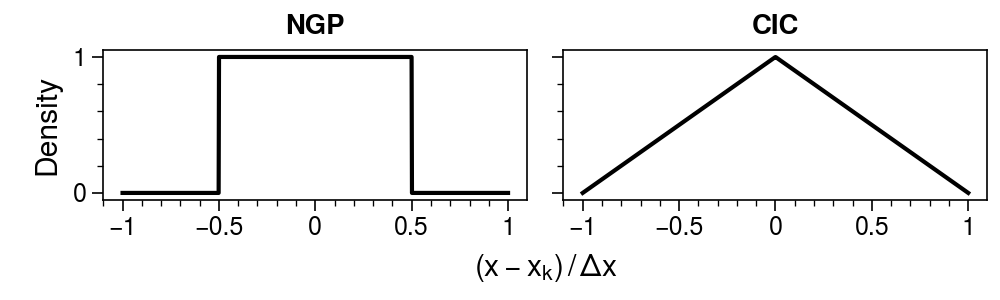

In [8]:
#hide_input
def shape_func(u, v, cell_width, method='ngp'):
    S, diff = 0, np.abs(u - v)
    if method == 'ngp':
        S = 1 if diff < (0.5 * cell_width) else 0
    elif method == 'cic':
        S = 1 - diff/cell_width if diff < cell_width else 0
    return S / cell_width

fig, axes = plot.subplots(ncols=2, figsize=(5, 1.5))
xvals = np.linspace(-1, 1, 1000)
for ax, method in zip(axes, ['ngp', 'cic']):
    densities = [shape_func(x, 0, 1, method) for x in xvals]
    ax.plot(xvals, densities, 'k')
axes.format(xlabel='($x - x_k) \,/\, \Delta x$', ylabel='Density', grid=False, 
            xlabel_kw={'size':'large'}, ylabel_kw={'size':'large'}, 
            toplabels=['NGP', 'CIC'])

We see that the NGP method leads to a discontinuous boundary, while the CIC method leads to a continous boundary (but discontinous derivative). There are also higher order methods which lead to a smooth boundary, but I don't cover those here. 

We also need to perform the reverse operation: given the electric field at each grid point, interpolate the value at each particle position. The same method applies here. NGP just uses the electric field at the nearest grid point, while CIC weights the four nearest grid points. The following `Grid` class implements the CIC method. Notice that I utilized [Cython](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html) in the for-loop in the `distribute` method. I couldn't figure out a way to perform the operation with this loop, and in pure Python it took about 90% of the runtime for a single simulation step. Using Cython gave at least a 5X speed up.

In [9]:
%%cython
import numpy as np
from scipy.interpolate import RegularGridInterpolator

class Grid:
    """Class for 2D grid.

    Attributes
    ----------
    xmin, ymin, xmax, ymax : float
        Minimum and maximum coordinates.
    Nx, Ny : int
        Number of grid points.
    dx, dy : int
        Spacing between grid points.
    x, y : ndarray, shape (Nx,) or (Ny,)
        Positions of each grid point.
    cell_area : float
        Area of each cell.
    """
    def __init__(self, xlim=(-1, 1), ylim=(-1, 1), size=(64, 64)):
        self.xlim, self.ylim = xlim, ylim
        (self.xmin, self.xmax), (self.ymin, self.ymax) = xlim, ylim
        self.size = size
        self.Nx, self.Ny = size
        self.dx = (self.xmax - self.xmin) / (self.Nx - 1)
        self.dy = (self.ymax - self.ymin) / (self.Ny - 1)
        self.cell_area = self.dx * self.dy
        self.x = np.linspace(self.xmin, self.xmax, self.Nx)
        self.y = np.linspace(self.ymin, self.ymax, self.Ny)
        
    def set_lims(self, xlim, ylim):
        """Set the min and max grid coordinates."""
        self.__init__(xlim, ylim, self.size)
        
    def zeros(self):
        """Create array of zeros with same size as the grid."""
        return np.zeros((self.size))

    def distribute(self, positions):
        """Distribute points on the grid using the cloud-in-cell (CIC) method.
        
        Parameters
        ----------
        positions : ndarray, shape (n, 2)
            List of (x, y) positions.
            
        Returns
        -------
        rho : ndarray, shape (Nx, Ny)
            Density at each grid point.
        """
        # Compute area overlapping with 4 nearest neighbors
        ivals = np.floor((positions[:, 0] - self.xmin) / self.dx).astype(int)
        jvals = np.floor((positions[:, 1] - self.ymin) / self.dy).astype(int)
        ivals[ivals > self.Nx - 2] = self.Nx - 2
        jvals[jvals > self.Ny - 2] = self.Ny - 2
        x_i, x_ip1 = self.x[ivals], self.x[ivals + 1]
        y_j, y_jp1 = self.y[jvals], self.y[jvals + 1]
        _A1 = (positions[:, 0] - x_i) * (positions[:, 1] - y_j)
        _A2 = (x_ip1 - positions[:, 0]) * (positions[:, 1] - y_j)
        _A3 = (positions[:, 0] - x_i) * (y_jp1 - positions[:, 1])
        _A4 = (x_ip1 - positions[:, 0]) * (y_jp1 - positions[:, 1])
        # Distribute areas for each point
        rho = self.zeros()
        cdef double[:, :] rho_view = rho 
        cdef int i, j
        for i, j, A1, A2, A3, A4 in zip(ivals, jvals, _A1, _A2, _A3, _A4):
            rho_view[i, j] += A4
            rho_view[i + 1, j] += A3
            rho_view[i, j + 1] += A2
            rho_view[i + 1, j + 1] += A1      
        return rho / self.cell_area

    def interpolate(self, grid_vals, positions):
        """Interpolate values from the grid using the CIC method.
        
        Parameters
        ----------
        positions : ndarray, shape (n, 2)
            List of (x, y) positions.
        grid_vals : ndarray, shape (n, 2)
            Scalar value at each coordinate point.
            
        Returns
        -------
        int_vals : ndarray, shape (nparts,)
            Interpolated value at each position.
        """
        int_func = RegularGridInterpolator((self.x, self.y), grid_vals)
        return int_func(positions)

    def gradient(self, grid_vals):
        """Compute gradient using 2nd order centered differencing.
        
        Parameters
        ----------
        grid_vals : ndarray, shape (Nx, Ny)
            Scalar values at each grid point.
        neg : Bool
            If True, return the negative of the gradient.
            
        Returns
        -------
        gradx, grady : ndarray, shape (Nx, Ny)
            The x and y gradient at each grid point.
        """
        return np.gradient(grid_vals, self.dx, self.dy)

It should be mentioned that the field interpolation method should be the same as the charge deposition method; if this is not true, it is possible for a particle to exert a force on itself! The `RegularGridInterpolator` class implements this for us, but I couldn't find anything similar to deposit the charges. Let's test the method on a gaussian distribution of 100,000 macroparticles in the $x$-$y$ plane, truncated at three standard devations. We'll choose the number of grid points to be $N_x = N_y = 64$. I call a `DistGenerator` class that I don't show here.

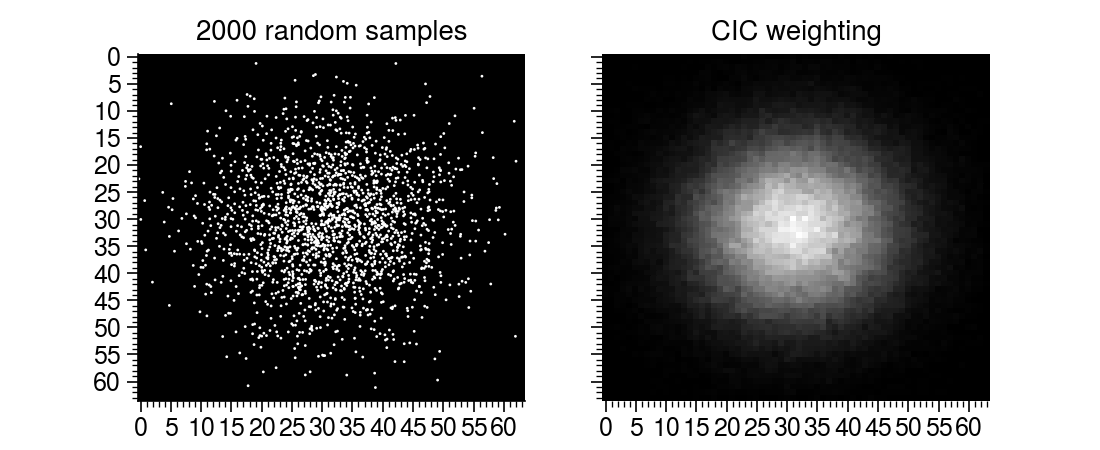

In [10]:
dist_gen = DistGenerator()
X = dist_gen.generate(kind='gauss', nparts=100000, cut=3)
bunch = Bunch()
bunch.fill(X)
bunch.compute_extremum()
grid = Grid(bunch.xlim, bunch.ylim, size=(64, 64))
rho = bunch.macrocharge * grid.distribute(bunch.positions)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5, 2.25), sharey=True, sharex=True)
X_samp = rand_rows(X, 2000)
x = (X_samp[:, 0] - grid.xmin) / grid.dx
y = (X_samp[:, 2] - grid.ymin) / grid.dy
ax1.set_facecolor('k')
ax1.scatter(x, y, s=1, c='w', ec='none')
ax1.grid(False)
myplt.despine([ax1])
sns.heatmap(rho.T, ax=ax2, cmap='binary_r', cbar=False)
myplt.set_labels((ax1, ax2), ['2000 random samples', 'CIC weighting'], 'title');

### Field solver 

The workhorse in the simulation loop is the field solver. We need to solve Poisson's equation:

$$\left({\frac{\partial^2}{dx^2} + \frac{\partial^2}{dy^2}}\right) = -\frac{\rho\left(x, y\right)}{\varepsilon_0}. \tag{6}$$

The discretized version of the equation reads

$$ \frac{\phi_{i+1,j} + -2\phi_{i,j} +\phi_{i-1,j}}{{\Delta_x}^2} + \frac{\phi_{i,j+1} + -2\phi_{i,j} + \phi_{i,j-1}}{{\Delta_y}^2} = -\frac{\rho_{i,j}}{\varepsilon_0} \tag{7}$$

for a grid with spacing $\Delta_x$ and $\Delta_y$. There are multiple paths to a solution; we will focus on the method implemented in PyORBIT, which utilizes the Fourier convolution theorem. 

#### Green's functions and convolution theorem

The potential from an infinite line charge at the origin with charge density $\lambda$ is 

$$ \phi(\mathbf{x}) = -\frac{\lambda}{2\pi\varepsilon_0} \ln{|\mathbf{x}|} = -\frac{\lambda}{2\pi\varepsilon_0} \int{\ln{|\mathbf{x} - \mathbf{q}|}\delta(\mathbf{q})d\mathbf{q}}. \tag{8}$$

Note that $\mathbf{q}$ is just a dummy variable; usually a prime is used, but we already assigned physical meaning to $\mathbf{x}'$. By defining $G(\mathbf{x} - \mathbf{q}) = -\frac{\lambda}{2\pi\varepsilon_0} \ln{|\mathbf{x} - \mathbf{q}|}$ and $\rho(\mathbf{x}) = \delta(\mathbf{x})$, we have

$$ \phi(\mathbf{x}) = \int{G(\mathbf{x} - \mathbf{q})\rho(\mathbf{q})d\mathbf{q}} = G(\mathbf{x}) * \rho(\mathbf{x}). \tag{9}$$

In this form the potential is a [convolution](https://en.wikipedia.org/wiki/Convolution) (represented by $*$) of the transverse charge density $\rho$ with $G$, which is called the [Green's function](https://en.wikipedia.org/wiki/Green%27s_function). On the grid this will look like

$$ \phi_{i, j} = \sum_{k,l \ne i,j}{G_{i-k, j-l} \rho_{k, l}}. \tag{11}$$

This solves the problem in $O(N^2)$ time complexity for $N$ grid points. This is already much faster than a direct force calculation but could still get expensive for fine grids. We can speed things up by exploiting the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem), which says that the Fourier transform of a convolution of two functions is equal to the product of their Fourier transforms. The Fourier transform is defined by

$$\hat{\phi}(\mathbf{k})= \mathcal{F}\left[\phi(\mathbf{x})\right] = \int_{-\infty}^{\infty}{e^{-\mathbf{k}\cdot\mathbf{x}} \phi(\mathbf{x}) d\mathbf{x}}. \tag{12}$$

The convolution theorem then says
$$\mathcal{F}\left[\rho * G\right] = \mathcal{F}\left[\rho\right] \cdot \mathcal{F}\left[G\right]. \tag{13}$$

The dot represents the pointwise product. For the discrete equation this gives

$$\hat{\phi}_{n, m} = \hat{\rho}_{n, m} \hat{G}_{n, m}, \tag{14}$$

where the hat represents the [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (DFT). With the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) algorithm at our disposal, the time complexity can be reduced to $O\left(N \log N\right)$. 

#### Implementation

There is a caveat to this method: to use the FFT algorithm, Eq. (11) must be a circular convolution, which means $G$ must be periodic. But the beam is in free space (we've neglected any conducting boundary), so this is not true. We can make it true by doubling the grid size in each dimension. We then make $G$ a mirror reflection in the new quadrants so that it is periodic, and also set the charge density equal to zero in these regions. After running the method on this larger grid, the potential in the new quadrants will be unphysical; however, the potential in the original quadrant will be correct. There are also some tricks we can play to reduce the space complexity, and in the end doubling the grid size is not much of a price to pay for the gain in speed. The method is implemented in the `PoissonSolver` class.

In [11]:
from scipy.fft import fft2, ifft2

class PoissonSolver:
    """Class to solve Poisson's equation on a 2D grid.

    Attributes
    ----------
    rho, phi, G : ndarray, shape (2*Nx, 2*Ny)
        Charge density (rho), potential (phi), and Green's function (G) at each
        grid point on a doubled grid. Only one quadrant (i < Nx, j < Ny)
        corresponds to to the real potential.
    """
    def __init__(self, grid):
        self.grid = grid
        new_shape = (2 * self.grid.Nx, 2 * self.grid.Ny)
        self.rho, self.G = np.zeros(new_shape), np.zeros(new_shape)
        self.phi = np.zeros(new_shape)
        
    def set_grid(self, grid):
        self.__init__(grid)
        
    def _compute_greens_function(self, line_charge_density):
        """Compute Green's function on doubled grid."""
        Nx, Ny = self.grid.Nx, self.grid.Ny
        Y, X = np.meshgrid(self.grid.x - self.grid.xmin,
                           self.grid.y - self.grid.ymin)
        self.G[:Nx, :Ny] = np.log(X**2 + Y**2, out=np.zeros_like(X),
                                  where=(X+Y>0))
        self.G *= -0.5 * line_charge_density / (2 * pi * epsilon_0)
        self.G[Nx:, :] = np.flip(self.G[:Nx, :], axis=0)
        self.G[:, Ny:] = np.flip(self.G[:, :Ny], axis=1)
                
    def get_potential(self, rho, line_charge_density):
        """Compute the electric potential on the grid.
        
        Parameters
        ----------
        rho : ndarray, shape (Nx, Ny)
            Charge density at each grid point [C / m^2].
        line_charge_density : float
            Longitudinal charge density [C / m].
        
        Returns
        -------
        phi : ndarray, shape (Nx, Ny)
            Electric potential at each grid point.
        """
        Nx, Ny = self.grid.Nx, self.grid.Ny
        self.rho[:Nx, :Ny] = rho
        self._compute_greens_function(line_charge_density)
        self.phi = ifft2(fft2(self.G) * fft2(self.rho)).real
        return self.phi[:Nx, :Ny]

Running the algorithm gives the following potential on the doubled grid:

In [12]:
solver = PoissonSolver(grid)
phi = solver.get_potential(rho, bunch.line_charge_density)

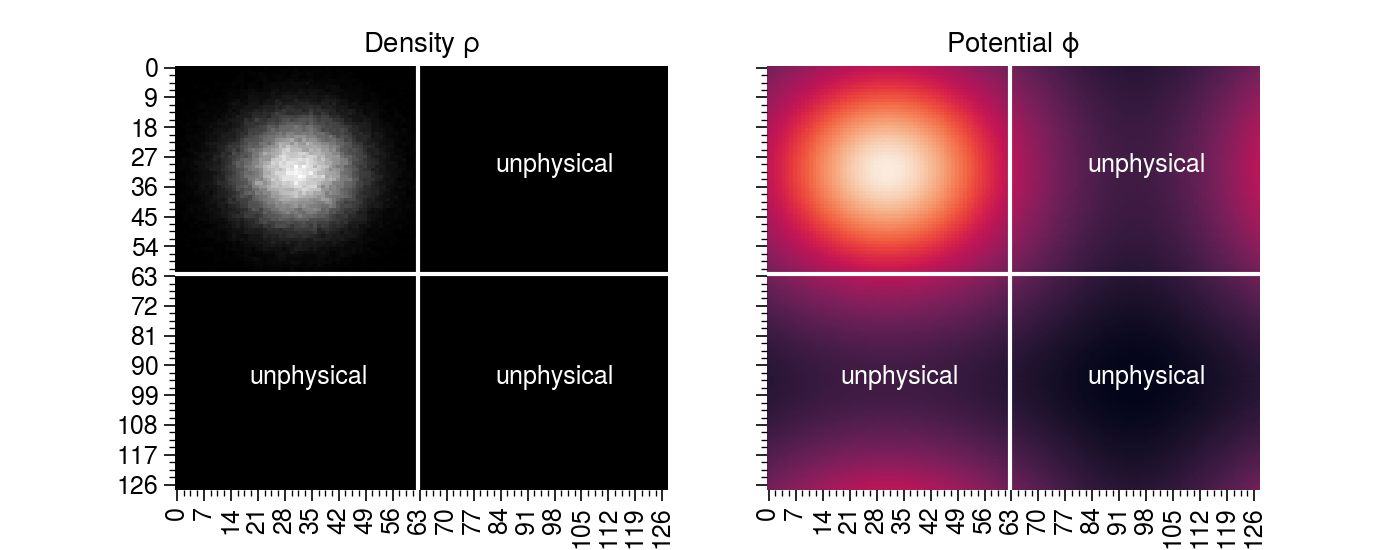

In [13]:
#hide_input
fig, axes = plt.subplots(ncols=2, figsize=(7, 2.75), sharey=True)
sns.heatmap(solver.rho.T, ax=axes[0], cmap='binary_r', cbar=False)
sns.heatmap(solver.phi.T, ax=axes[1], cbar=False)
for ax in axes:
    ax.axvline(63, c='w'); ax.axhline(63, c='w')
    for xy in [(0.65, 0.75), (0.15, 0.25), (0.65, 0.25)]:
        ax.annotate('unphysical', xy=xy, xycoords='axes fraction', c='w')
myplt.set_labels(axes, [r'Density $\rho$', r'Potential $\phi$'], 'title')

We can then compute the electric field at every grid point using second-order centered differencing. This gives

$$(E_x)_{i,j} = -\frac{\phi_{i+1,j} - \phi_{i-1,j}}{2\Delta_x}, $$

$$(E_y)_{i,j} = -\frac{\phi_{i,j+1} - \phi_{i,j-1}}{2\Delta_y}. $$

In [14]:
Ex, Ey = grid.gradient(-phi)

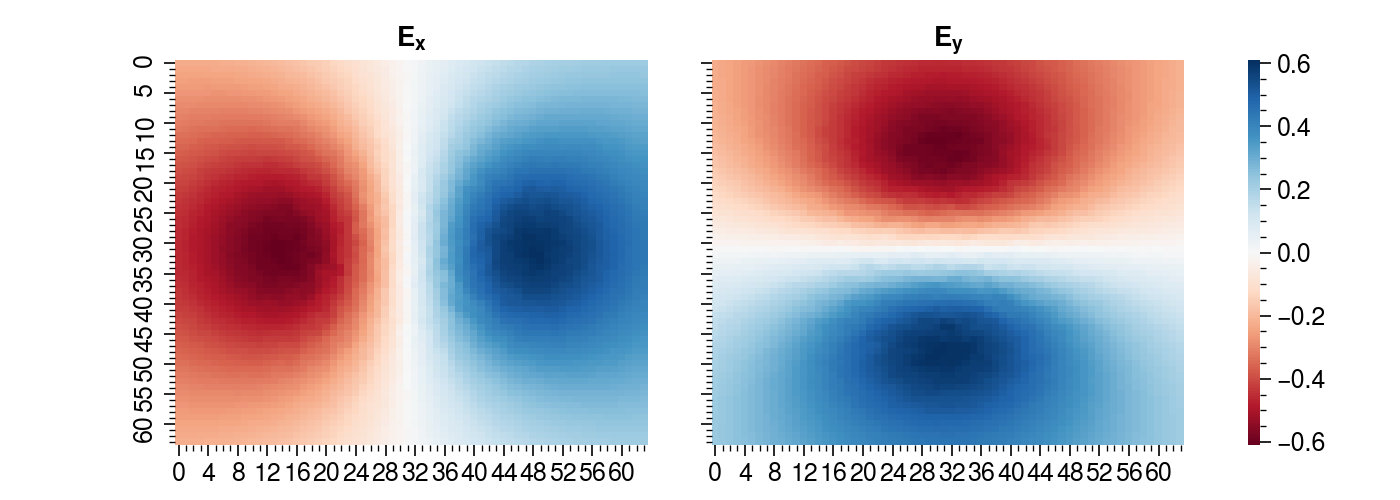

In [15]:
#hide_input
fig, axes = plt.subplots(ncols=3, figsize=(7, 2.5), 
                         gridspec_kw=dict(width_ratios=[1, 1, 0.025]))
ax1, ax2, ax3 = axes
myplt.set_share_axes(axes[:2], sharex=True, sharey=True)
sns.heatmap(Ex.T, ax=ax1, cmap='RdBu', cbar=False);
sns.heatmap(Ey.T, ax=ax2, cmap='RdBu', cbar_ax=ax3);
myplt.set_labels(axes[:2], ['$E_x$', '$E_y$'], 'title', fontweight='bold');

Finally, the value of the electric field at each particle position can be interpolated.

In [16]:
Ex_int = grid.interpolate(Ex, bunch.positions)
Ey_int = grid.interpolate(Ey, bunch.positions)

### Particle mover 

All we need to do in this step is integrate the equations of motion. One common method is [leapfrog integration](https://en.wikipedia.org/wiki/Leapfrog_integration) in which the position and velocity are integrated out of phase as follows:

$$ m\left(\frac{\mathbf{v}_{i+1/2} - \mathbf{v}_{i-1/2}}{\Delta_t}\right) = \mathbf{F}(\mathbf{x}_i),$$

$$ \frac{\mathbf{x}_{i+1} - \mathbf{x}_i}{\Delta_t} = \mathbf{v}_{i+1/2}$$

<img src='images_2021-02-15/leapfrog.png' width=500>
<figcaption>Credit: Steven Lund</figcaption>

I should also mention that a different scheme must be used when magnetic fields are present. This is a symplectic integrator, which means it conserves energy. It is also second-order accurate, meaning that its error is proportional to the square of the $\Delta_t$. Finally, it is time-reversible. Because the velocity and position are out of phase, we need to push the velocity back one half-step before starting the simulation, and push it one half-step forward when taking a measurement. 

## Putting it all together

### Simulation loop

We have all the tools to implement the simulation loop. While $s < s_{max}$ we: 
1. Compute the charge density on the grid.
2. Find the electric potential on the grid.
3. Interpolate the electric field at the particle positions.
3. Update the particle positions.

We'll first create a `History` class which stores the beam moments or phase space coordinates.

In [17]:
class History:
    """Class to store bunch data over time.
    
    moments : list
        Beam moment vectors; each element is ndarray of shape (10,).
    coords : list
        Bunch coordinate arrays.
    moment_positions, coord_positions : list
        Positions corresponding to each element of `moments` or `coords`.
    """
    def __init__(self, bunch, samples=None):
        self.X = bunch.X
        self.moments, self.coords = [], []
        self.moment_positions, self.coord_positions = [], []
        if samples is None or samples >= bunch.nparts:
            self.Xsamp = self.X
        else:
            idx = np.random.choice(bunch.nparts, samps, replace=False)
            self.Xsamp = self.X[idx, :]
        
    def store_moments(self, s):
        Sigma = np.cov(self.X.T)
        self.moments.append(Sigma[np.triu_indices(4)])
        self.moment_positions.append(s)
        
    def store_coords(self, s):
        self.coords.append(np.copy(self.Xsamp))
        self.coord_positions.append(s)
        
    def package(self, mm_mrad):
        self.moments = np.array(self.moments)
        self.coords = np.array(self.coords)
        if mm_mrad:
            self.moments *= 1e6
            self.coords *= 1e3

Now we'll create a `Simulation` class.

In [18]:
class Simulation:
    """Class to simulate the evolution of a charged particle bunch.
    
    It can only handle a beam in free space, i.e., no conducting boundaries.
    
    Attributes
    ----------
    bunch : Bunch object:
        The bunch to track.
    length : float
        Total tracking distance [m].
    ds : float
        Distance between force calculations.
    nsteps : float
        Total number of steps = length / ds.
    steps_performed : int
        The number of steps performed so far.
    s : float
        The current bunch position.
    positions : ndarray, shape (nsteps + 1,)
        Positions at which coordinates are updated.
    sc_calc : bool
        Whether to perform spcae charge calculations.
    self.history : History object
        Object storing the bunch data at each position.
    meas_freq : float
        Number of steps between bunch measurements. We can store the moments or
        the full coordinate array; if one number is provided, both of these
        are stored at each measurement. If a tuple is provided, the first
        number corresponds to the moments, and the second to the coordinates.
        Default is to store the initial and final coordinates, and to store the
        moments at every simulation step.
    samples : int
        Number of bunch particles to store when measuring the phase space
        coordinates. If None, the entire coordinate array is kept.
    ext_kick : callable or None
        Function which takes as inputs (x, x', y, y', s) and returns the
        changes in slopes (fx, fy), such that x'' = fx and y'' = fy.
    Ex, Ey : ndarray, shape (nparts,)
        The horizontal and vertical component of the self-generated electric
        field at the location of each particle. These are stored so that the
        positions and slopes can be synchronized without solving Poisson's
        equation again.
    mm_mrad : bool
        If True, use units of mm-mrad. Otherwise use m-rad.
    """
    def __init__(self, bunch, length, ds, grid_size, sc_calc=True,
                 meas_freq=None, samples=None, nparts_store=None, ext_kick=None,
                 mm_mrad=True):
        self.bunch = bunch
        self.length, self.ds, self.nsteps = length, ds, int(length / ds)
        self.positions = np.linspace(0, length, self.nsteps + 1)
        self.steps_performed = 0
        self.s = 0.
        self.mm_mrad = mm_mrad
        self.grid = Grid(size=grid_size)
        self.solver = PoissonSolver(self.grid)
        self.sc_calc = sc_calc
        if meas_freq is None:
            meas_freq = self.nsteps
        if type(meas_freq) is int:
            meas_freq = (meas_freq, meas_freq)
        self.meas_freq = meas_freq
        self.history = History(bunch, samples)
        self.ext_kick = ext_kick
        self.Ex = np.zeros(bunch.nparts)
        self.Ey = np.zeros(bunch.nparts)
        
    def set_grid(self):
        """Determine grid limits."""
        self.bunch.compute_extremum()
        self.grid.set_lims(self.bunch.xlim, self.bunch.ylim)
        self.solver.set_grid(self.grid)
        
    def compute_electric_field(self):
        """Compute the self-generated electric field."""
        self.set_grid()
        rho = self.grid.distribute(self.bunch.positions)
        phi = self.solver.get_potential(rho, self.bunch.line_charge_density)
        Ex, Ey = self.grid.gradient(-phi)
        self.Ex = self.grid.interpolate(Ex, self.bunch.positions)
        self.Ey = self.grid.interpolate(Ey, self.bunch.positions)
                            
    def kick(self, ds):
        """Update particle slopes."""
        self.bunch.X[:, 1] += self.bunch.sc_factor * self.Ex * ds
        self.bunch.X[:, 3] += self.bunch.sc_factor * self.Ey * ds
        if self.ext_kick is not None:
            fx, fy = self.ext_kick()
        
    def push(self, ds):
        """Update particle positions."""
        self.bunch.X[:, 0] += self.bunch.X[:, 1] * ds
        self.bunch.X[:, 2] += self.bunch.X[:, 3] * ds
        
    def sync(self):
        """Advance velocity one half step backward."""
        self.kick(-0.5 * self.ds)
        
    def desync(self):
        """Advance velocity one half step forward."""
        self.kick(0.5 * self.ds)
        
    def store(self):
        """Store the bunch coordinates or statistics."""
        store_moments = self.steps_performed % self.meas_freq[0] == 0
        store_coords = self.steps_performed % self.meas_freq[1] == 0
        if not (store_moments or store_coords):
            return
        xp_old = np.copy(self.bunch.X[:, 1])
        yp_old = np.copy(self.bunch.X[:, 3])
        Xp = np.copy(self.bunch.X[:, [1, 3]])
        self.sync()
        if store_moments:
            self.history.store_moments(self.s)
        if store_coords:
            self.history.store_coords(self.s)
        self.bunch.X[:, [1, 3]] = Xp
        
    def run(self):
        """Run the simulation."""
        self.compute_electric_field()
        self.store()
        self.desync()
        for i in trange(self.nsteps):
            if self.sc_calc:
                self.compute_electric_field()
            self.kick(self.ds)
            self.push(self.ds)
            self.s += self.ds
            self.steps_performed += 1
            self.store()
        self.history.package(self.mm_mrad)

### Test: KV distribution 

Now the question is: how do we know if our code is correct? There is a special class of distributions which are exact solutions to the Vlasov equation. One example is called the KV distribution. The beam projects to a uniform density, upright ellipse in the $x$-$y$ plane, leading to linear space charge forces, and this property will be maintained as long as the external focusing is linear. As a consequence, we can write down a set of easily solvable differential equations for the covariance matrix of the distribution. We call this the beam *envelope*. For now I won't even show these equations; we'll just use them. Perhaps a future post will be devoted to self-consistent beams, since they are a ver important and interesting subject. We'll use a hidden `EnvelopeSolver` class which integrates the envelope equations.

In [19]:
#hide
from scipy.integrate import solve_ivp

def k_drift(s):
    """Return focusing strength at position s in a drift."""
    return 0.
    
def k_fodo(s):
    """Return focusing strength at position s in a FODO lattice."""
    return 0.
    
def chernin(s, sigma, Q, focusing_strength):
    """Compute derivative of 10 element moment vector `sigma`."""
    # Focusing strength in lattice (assume no skew elements for now)
    k0x = focusing_strength(s)
    k0y = -k0x
    k0xy = 0.0
    # Space charge terms
    s11, s12, s13, s14, s22, s23, s24, s33, s34, s44 = sigma
    S0 = np.sqrt(s11*s33 - s13**2)
    Sx, Sy = s11 + S0, s33 + S0
    D = S0 * (Sx + Sy)
    psi_xx, psi_yy, psi_xy = Sy/D, Sx/D, -s13/D
    # Modified focusing strength
    kx = (Q/2)*psi_xx - k0x
    ky = (Q/2)*psi_yy - k0y
    kxy = (Q/2)*psi_xy + k0xy
    # Derivatives
    sigma_p = np.zeros(10)
    sigma_p[0] = 2 * s12
    sigma_p[1] = s22 + kx*s11 + kxy*s13
    sigma_p[2] = s23 + s14
    sigma_p[3] = s24 + kxy*s11 + ky*s13
    sigma_p[4] = 2*kx*s12 + 2*kxy*s23
    sigma_p[5] = s24 + kx*s13 + kxy*s33
    sigma_p[6] = kx*s14 + kxy*(s34+s12) + ky*s23
    sigma_p[7] = 2 * s34
    sigma_p[8] = s44 + kxy*s13 + ky*s33
    sigma_p[9] = 2*kxy*s14 + 2*ky*s34
    return sigma_p
        
        
class EnvelopeSolver:
    """Class to track the rms beam envelope assuming a uniform density ellipse.
    
    Attributes
    ----------
    positions : ndarray, shape (nsteps + 1,)
        Positions at which to evaluate.
    Sigma0 : ndarray, shape (4, 4):
        Initial covariance matrix.
    sigma0 : ndarray, shape (10,)
        Initial moment vector (upper-triangular elements of `Sigma`. Order is :
        ['x2','xxp','xy','xyp','xp2','yxp','xpyp','y2','yyp','yp2'].
    sigma : ndarray, shape (nsteps + 1, 10)
        Beam moment vector at each position.
    Q : float
        Dimensionless beam perveance.
    k : callable
        Function which returns the horizontal focusing strength at position s.
        Call signature is `strength = k(s)`.
    mm_mrad : bool
        Whether to convert units to mm-mrad.
    """
    def __init__(self, Sigma0, positions, perveance, k=k_drift, mm_mrad=True):
        self.sigma0 = Sigma0[np.triu_indices(4)]
        self.positions, self.Q, self.k = positions, perveance, k
        self.mm_mrad = mm_mrad
                
    def integrate(self):
        """Integrate the envelope equations."""
        s_span = (self.positions[0], self.positions[-1])
        sol = solve_ivp(chernin, s_span, self.sigma0, args=(self.Q, self.k),
                        t_eval=self.positions, atol=1e-12)
        self.moments = sol.y.T
        if self.mm_mrad:
            self.moments *= 1e6

Let's track the KV distribution over 20 meters, tracking every 2 centimeters. Keep in mind that the bunch is traveling near 90% of the speed of light.

In [ ]:
# Simulation settings
sim_length = 15.0 # [m]
ds = 0.05 # [m]
grid_size = (64, 64)
meas_freq = (10, 2) # moments, coords

# Create bunch
X = dist_gen.generate('kv', nparts=int(1e5))
bunch = Bunch()
bunch.fill(X)
Sigma0 = np.cov(X.T) # Store covariance matrix for envelope solver

# Run PIC simulation
sim = Simulation(bunch, sim_length, ds, grid_size, meas_freq=meas_freq)
sim.run()

# Integrate envelope equations
env_solver = EnvelopeSolver(Sigma0, sim.positions, bunch.perveance)
env_solver.integrate()

 19%|█▊        | 56/300 [00:05<00:23, 10.56it/s]

In [ ]:
# hide
columns = ['x2','xxp','xy','xyp','xp2','yxp','xpyp','y2','yyp','yp2']
def make_df(moments, positions):
    df = pd.DataFrame(moments, columns=columns)
    df[['x_rms','y_rms']] = np.sqrt(df[['x2','y2']])
    df['s'] = positions
    return df.copy()

In [ ]:
# hide_input
moments = make_df(sim.history.moments, sim.history.moment_positions)
moments_theory = make_df(env_solver.moments, env_solver.positions)

fig, axes = plot.subplots(ncols=2, figsize=(5, 2.5), spany=False)
for ax, key in zip(axes, ['x_rms', 'y_rms']):
    moments_theory[['s', key]].plot('s', ax=ax, legend=False, color='k')
    moments[['s', key]].plot('s', ax=ax, legend=False, color='r', 
                             marker='.', lw=0)
myplt.set_labels(axes, ['Horizontal', 'Vertical'], 'title')
axes.format(ylabel='Rms beam size [$mm$]', xlabel='position [m]', suptitle='Benchmark')
axes[1].legend(labels=['theory', 'calc'], ncols=1);

The agreement is quite good, and we expect some small fluctuations when we calculate the moments. The same PyORBIT simulation, which calls C++ routines directly (without storing any of the beam coordinates) is about 10 times faster, but I was quite happy with the performance.

In [ ]:
myanim.corner(sim.history.coords, samples=10000, dims=('x', 'y'), figsize=(4, 4), fps=5,
              text_fmt='s = {:.2f}', text_vals=sim.history.coord_positions, color='k')

### Test: Gaussian distribution 

Due to many different factors, real bunches tend to have more of a Gaussian distribution. Such a distribution introduces nonlinear forces, and there is no longer an exact theoretical benchmark we can turn to. Let's track a Gaussian bunch with the same parameters as before.

In [ ]:
X = dist_gen.generate('gauss', nparts=int(1e5), eps=(25e-6, 25e-6), cut=3)
bunch = Bunch()
bunch.fill(X)

sim_gauss = Simulation(bunch, sim_length, ds, grid_size, meas_freq=meas_freq)
sim_gauss.run()

In [ ]:
myanim.corner(sim_gauss.history.coords, samples=10000, dims=('x', 'y'), figsize=(4, 4), fps=5,
              text_fmt='s = {:.2f}', text_vals=sim_gauss.history.coord_positions, color='k')

In [ ]:
#hide
# Here we will put a side-by-side animation of KV vs. Gaussian

In [ ]:
#hide
# For filling factor of 0.1, and length 5.0 m, we have:
# kmax = 15.057025129311214 # 100 deg phase advance
# kmin = 13.892280461693252 # 90 deg phase advance

## Conclusion 

In this post we have implemented an electrostatic PIC simulation engine. With the help of NumPy and Cython, the code is about a factor of 10 slower than a well-tested accelerator physics code written in C++. I learned a lot by writing